## View the connectivity matrices in R to check for Liz to move on to more particles, longer releases

In [120]:
Packages <- c("dplyr","lattice", "ggplot2", "bbmle", "ncdf4","dplyr","tidyr", "stringr", "tidyverse", "raster", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')


In [167]:
#conn_mat <- nc_open("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD_2019.nc")
#time <- ncvar_get(conn_mat, "time")
conn_mat_all <- brick("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD_integer.nc", values=T) 

    

[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named sink BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named source BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named time BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"


In [148]:
{
    sink("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD_2019.txt")
 print(conn_mat)
    sink()
}

In [160]:
sites <- as.character(c("PAL", "WAN", "MAG", "CAB", "CAC", "CAP", "HIC", "HIS", "SIT", "ELS", "SIL", "SAG", "PSF", "POR", "PAN", "VIS", "GAB", "TAD", "HAI", "SIB", "SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "CAI", "Other"))
site_ind <- c(seq(1,28, 1))
site_id <- as.data.frame(cbind(sites, site_ind), stringsAsFactors = F)
site_id$site_ind <- as.numeric(site_id$site_ind)



In [150]:
length(sites)

[1] 28

In [161]:
col <- "date"
col2 <- "index"

season1 <- as.data.frame(seq(as.Date("2010/10/01"), as.Date("2011/05/31"), by="days"))
names(season1) <- col

season2 <- as.data.frame(seq(as.Date("2011/10/01"), as.Date("2012/05/31"), by="days"))
names(season2) <- col

season3 <- as.data.frame(seq(as.Date("2012/10/01"), as.Date("2013/05/31"), by="days"))
names(season3) <- col

season4 <- as.data.frame(seq(as.Date("2013/10/01"), as.Date("2014/04/18"), by="days"))
names(season4) <- col

all_dates <- bind_rows(season1, season2, season3, season4)
time_step <- as.data.frame(seq(1,930,1))
names(time_step)<- col2
all_dates2 <- bind_cols(time_step, all_dates)
dim(all_dates2)


[1] 930   2

In [152]:
tail(all_dates2)

,index,date
925,925,2014-04-13
926,926,2014-04-14
927,927,2014-04-15
928,928,2014-04-16
929,929,2014-04-17
930,930,2014-04-18


In [164]:
#make each daily connectivity matrix into a df and then pull them all together into a list
#conn_mat_list <- vector("list", nrow(all_dates2))

#date_df <- do.call("rbind", replicate(784, date, simplify = FALSE))

conn_mat_full <- as.data.frame(matrix(nrow=0, ncol=4))

cols_conn_mat <- c("date","source", "sink", "number")
cols_tmp <- c("source", "sink", "number")

names(conn_mat_full) <- cols_conn_mat

for(i in 1:nrow(all_dates2)){
    
    index_eval <- all_dates2$index[i]
    
    tmp <- as.data.frame(conn_mat_all[[i]], xy=T)   #pull out a data frame for each date
    names(tmp) <- cols_tmp
    
    date <- filter(all_dates2, index==index_eval)[2] #grab the date
    date_df <- do.call("rbind", replicate(784, date, simplify = FALSE)) #make a df of the date
    tmp2 <- bind_cols(date_df, tmp)

 
    conn_mat_full <- bind_rows(conn_mat_full, tmp2) 
}



In [165]:
head(conn_mat_full)

date,source,sink,number
2010-10-01,1,28,9
2010-10-01,2,28,4
2010-10-01,3,28,11
2010-10-01,4,28,12
2010-10-01,5,28,0
2010-10-01,6,28,1


In [128]:
nrow(tmp)
28*28

[1] 784

[1] 784

In [154]:
max(conn_mat_full$source) #this is 28, because it includes Camotes Islands and an "other" category, which the sites file does not


[1] 28

In [166]:
#read in the data for the number of grid cells per site (site ids are North- South, as in, Palanas is number 1)
sites_n <- read.table("~/oceanography/ROMS/input//camotes_vertices_sites_results_water_only.txt", sep=" ", header=T, stringsAsFactors = F)
#the order of sites in the connectivity matrix
sites_order <- read.table("~/oceanography/ROMS/input/sites_order_as_in_roms.txt", sep=" ", header=T, stringsAsFactors = F)

#when working with the fraction connectivity matrix
#read in the particles released per site
#col <- c("site", "seeded")
#seeded <- read.csv(file="~/oceanography/ROMS/data//Particles_Per_Release_Site.csv", header=F, col.names = col, stringsAsFactors = F)
#
#sites_n_seeded <- left_join(sites_n, seeded)
##add numbers on site table to join to the connectivity matrix, and then summarize to get the number of rows per site (as in, how many n grid cells per site)
#sites_ind <- left_join(sites_order, sites_n_seeded)# %>%
#    #group_by(site, site_number) #%>%
#    #summarize(n_grid_cells = n())
#
##now join together the connectivity matrix and the site metadata
#conn_mat_num <- left_join(conn_mat_full, sites_ind, by=c(source="site_number")) %>%
#        mutate(particle_number=fraction*(seeded))
#
#

In [64]:
#connect site names
conn_mat_full2 <- left_join(conn_mat_full, site_id, by=c(source="site_ind")) %>%
    dplyr::select(-source) %>%
    rename(source="sites")
    
conn_mat_full3 <- left_join(conn_mat_full2, site_id, by=c(sink="site_ind")) %>%
    dplyr::select(-sink) %>%
    rename(destination="sites")

    

In [65]:
#trim out sand flats for the sake of the prelims presentation
conn_mat_full4 <- conn_mat_full3 %>%
    filter(source != "SF1" & source != "SF2" & source != "SF3"
           & source != "SF4" & source != "SF5" & source != "SF6" & source != "PAN" & destination!= "PAN" & source != "Other") %>%
        mutate(month=month(ymd(date)))
#filter(destination != sandflat1 & destination != sandflat2 & source != sandflat3
      #     & source != sandflat4 & source != sandflat5 & source != sandflat6))

In [66]:
head(conn_mat_full4)

date,fraction,source,destination,month
2010-10-01,2.001010e-06,PAL,Other,10
2010-10-01,8.893379e-07,WAN,Other,10
2010-10-01,2.445679e-06,MAG,Other,10
2010-10-01,2.668014e-06,CAB,Other,10
2010-10-01,0.000000e+00,CAC,Other,10
2010-10-01,2.223345e-07,CAP,Other,10


In [67]:
#make into factors for plotting
#sand flats in correct position
#conn_mat_full4$source <-factor(conn_mat_full4$source, levels=c("PAL", "WAN", "MAG", "CAB", "CAC", "CAP", "HIC", "HIS", "SIT", "ELS", "SIL", "SAG", "PSF", "POR", "VIS", "GAB", "TAD", "HAI", "SIB", "Camotes_Islands"))
#conn_mat_full4$destination <-factor(conn_mat_full4$destination, levels=c("PAL", "WAN", "SF1", "MAG", "CAB","SF2", "CAC", "CAP", "SF3","HIC", "HIS", "SIT", "ELS", "SF4", "SIL", "SAG", "PSF", "POR", "VIS", "SF5", "GAB", "SF6","TAD", "HAI", "SIB", "Camotes_Islands", "Other"))

#sand flats at the far right so SR line is clear on diagonal
conn_mat_full4$source <-factor(conn_mat_full4$source, levels=c("PAL", "WAN", "MAG", "CAB", "CAC", "CAP", "HIC", "HIS", "SIT", "ELS", "SIL", "SAG", "PSF", "POR", "VIS", "GAB", "TAD", "HAI", "SIB", "CAI"))
conn_mat_full4$destination <-factor(conn_mat_full4$destination, levels=c("PAL", "WAN", "MAG", "CAB", "CAC", "CAP", "HIC", "HIS", "SIT", "ELS", "SIL", "SAG", "PSF", "POR", "VIS",  "GAB", "TAD", "HAI", "SIB", "CAI", "SF1", "SF2", "SF3", "SF4", "SF5", "SF6","Other"))



In [21]:
#make an average df
avg <- conn_mat_full4 %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))


In [68]:
#just each year's avg
avg12 <- conn_mat_full4 %>%
    filter(date >= "2012-01-01" & date <= "2012-12-31") %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))

avg13 <- conn_mat_full4 %>%
    filter(date >= "2013-01-01" & date <= "2013-12-31") %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))

avg14 <- conn_mat_full4 %>%
    filter(date >= "2014-01-01" & date <= "2014-12-31") %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))

#just each year's max
max12 <- conn_mat_full4 %>%
    filter(date >= "2012-01-01" & date <= "2012-12-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

max13 <- conn_mat_full4 %>%
    filter(date >= "2013-01-01" & date <= "2013-12-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

max14 <- conn_mat_full4 %>%
    filter(date >= "2014-01-01" & date <= "2014-12-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

In [29]:
#monsoon seasons
NEM_months <- c(11, 12, 1, 2, 3, 4)
SWM_months <- c(5, 6, 7, 8, 9, 10)

NEM <- conn_mat_full4 %>%
    filter(month %in% NEM_months) %>%
    group_by(source, destination) %>%
    summarise(conn=max(fraction))

SWM <- conn_mat_full4 %>%
    filter(month %in% SWM_months) %>%
    group_by(source, destination) %>%
    summarise(conn=max(fraction))

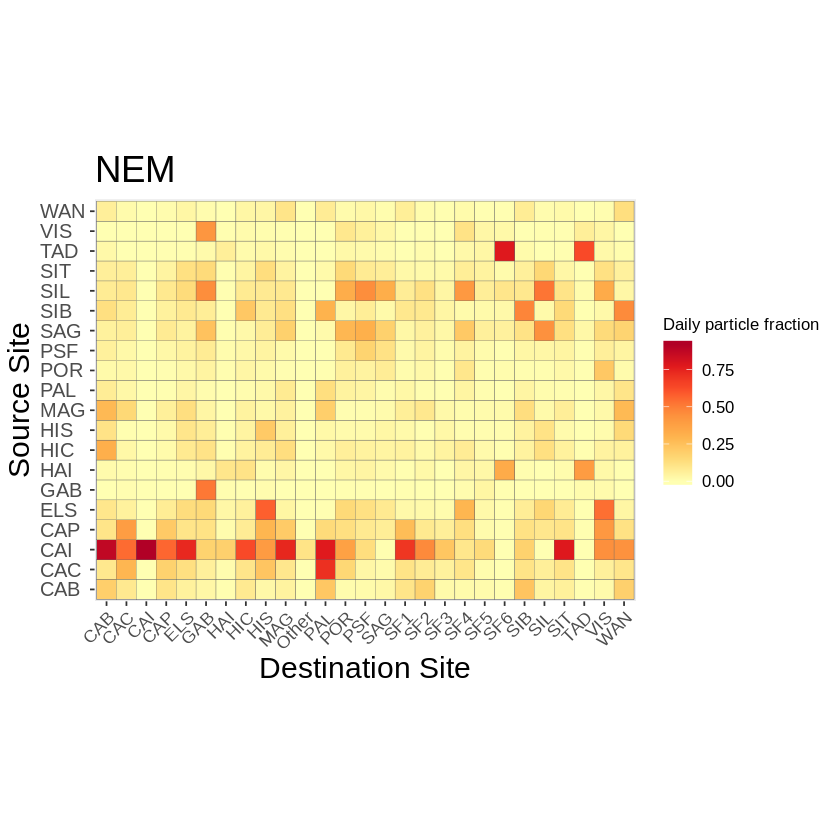

In [30]:
#NEM 
NEM_plot <- ggplot(NEM, aes(destination, source)) +
geom_tile(aes(fill = conn), color = "grey40") +
   geom_tile(aes(fill = conn), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
   scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("NEM") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())
NEM_plot

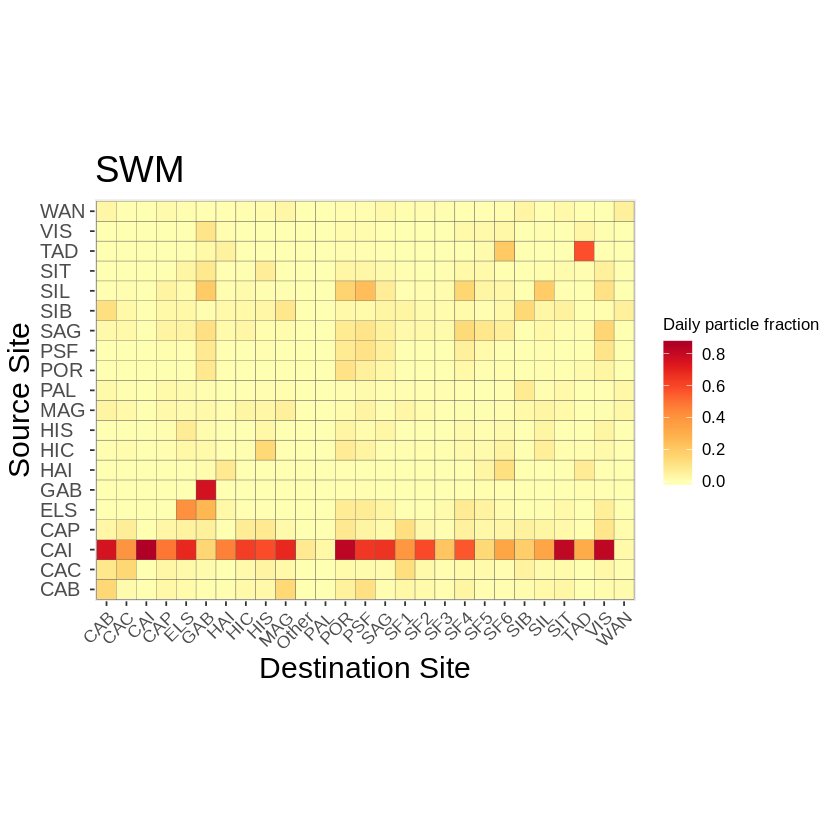

In [31]:
#NEM 
SWM_plot <- ggplot(SWM, aes(destination, source)) +
geom_tile(aes(fill = conn), color = "grey40") +
   geom_tile(aes(fill = conn), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
   scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("SWM") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())
SWM_plot

In [23]:
# try monthly
spring12 <- conn_mat_full4 %>%
    filter(date >= "2012-04-01" & date <= "2012-05-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

spring13 <- conn_mat_full4 %>%
    filter(date >= "2013-04-01" & date <= "2013-05-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

spring14 <- conn_mat_full4 %>%
    filter(date >= "2014-04-01" & date <= "2014-05-31") %>%
    group_by(source, destination) %>%
    summarise(max=max(fraction))

In [47]:
table(conn_mat_full4$source)
table(conn_mat_full4$destination)


            PAL             WAN             MAG             CAB             CAC 
          26040           26040           26040           26040           26040 
            CAP             HIC             HIS             SIT             ELS 
          26040           26040           26040           26040           26040 
            SIL             SAG             PSF             POR             VIS 
          26040           26040           26040           26040           26040 
            GAB             TAD             HAI             SIB Camotes_Islands 
          26040           26040           26040           26040           26040 
          Other 
              0 


            PAL             WAN             SF1             MAG             CAB 
          18600           18600           18600           18600           18600 
            SF2             CAC             CAP             SF3             HIC 
          18600           18600           18600           18600           18600 
            HIS             SIT             ELS             SF4             SIL 
          18600           18600           18600           18600           18600 
            SAG             PSF             POR             VIS             SF5 
          18600           18600           18600           18600           18600 
            GAB             SF6             TAD             HAI             SIB 
          18600           18600           18600           18600           18600 
Camotes_Islands           Other 
          18600           18600 

Saving 6.67 x 6.67 in image


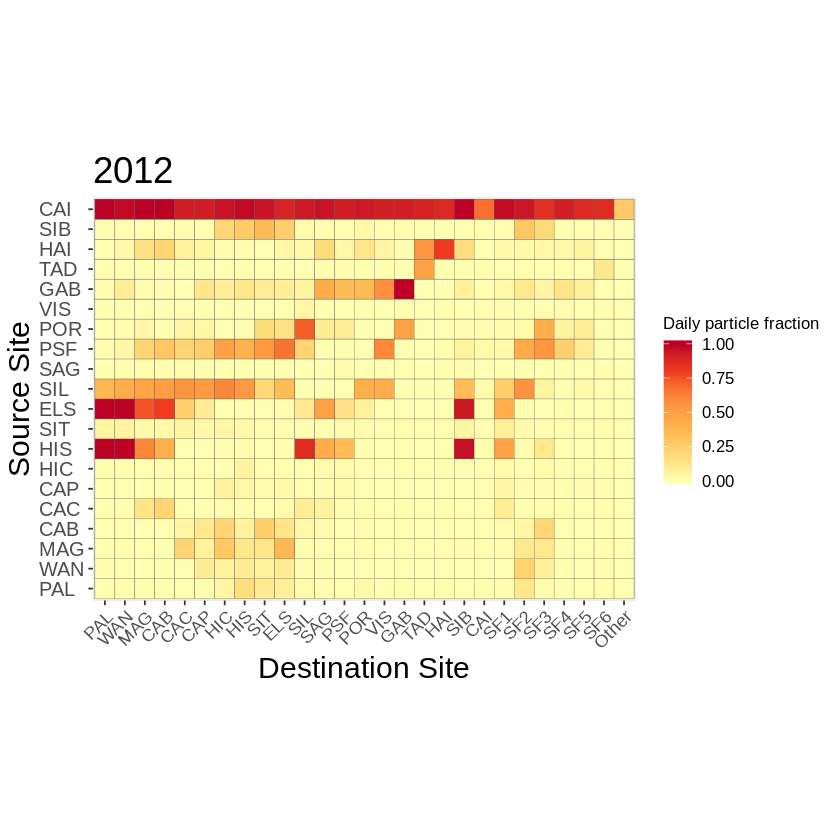

In [77]:
max12_plot <- ggplot(max12, aes(destination, source)) +
geom_tile(aes(fill = max), color = "grey40") +
   geom_tile(aes(fill = max), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
   scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("2012") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

max12_plot
ggsave(filename="ROMS_8day_conn_max12.png", plot=max12_plot, path="~/oceanography/figures" )



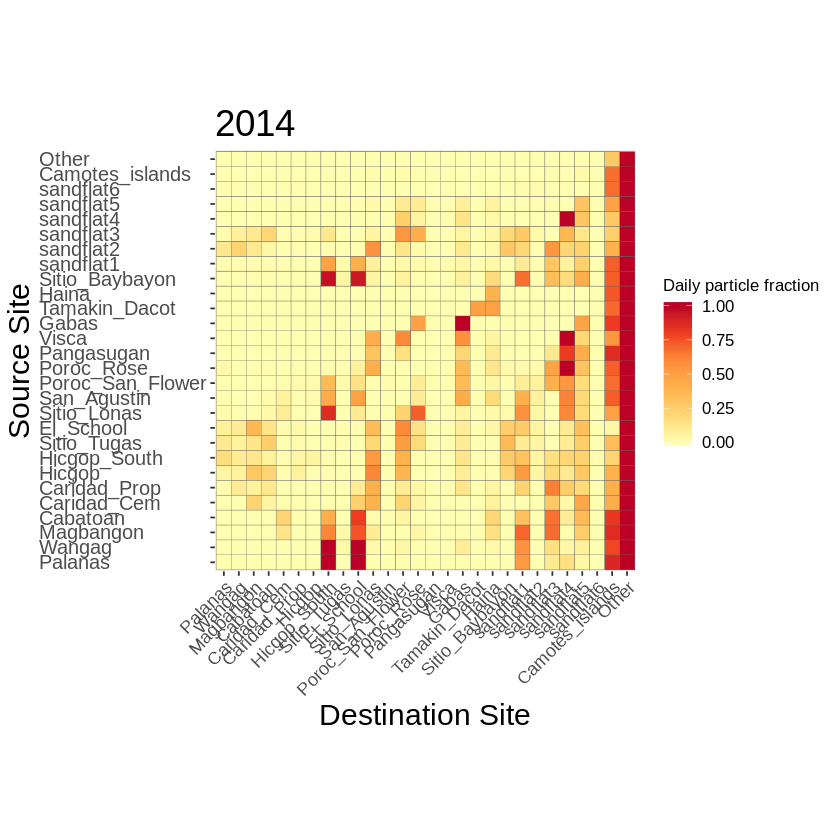

In [153]:

spring12_max <- ggplot(spring12, aes(source, destination)) +
geom_tile(aes(fill = max), color = "grey40") +
   geom_tile(aes(fill = max), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
   scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("2014") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

spring12_max
#ggsave(filename="ROMS_8day_conn14.png", plot=avg12_plot, path="~/oceanography/figures" )



## break into seasons for Malin's NSF submission



In [26]:
col <- "date"
col2 <- "index"

season1_test <- as.data.frame(seq(as.Date("2011/05/01"), as.Date("2011/10/31"), by="days"))
names(season1) <- col

season2_test <- as.data.frame(seq(as.Date("2011/11/01"), as.Date("2012/04/30"), by="days"))
names(season1) <- col


#make each daily connectivity matrix into a df and then pull them all together into a list
#conn_mat_list <- vector("list", nrow(all_dates2))

#date_df <- do.call("rbind", replicate(784, date, simplify = FALSE))

conn_mat_full <- as.data.frame(matrix(nrow=0, ncol=4))

cols_conn_mat <- c("date","source", "sink", "fraction")
cols_tmp <- c("source", "sink", "fraction")

names(conn_mat_full) <- cols_conn_mat

for(i in 1:nrow(all_dates2)){
    
    index_eval <- all_dates2$index[i]
    
    tmp <- as.data.frame(conn_mat_all[[i]], xy=T)   #pull out a data frame for each date
    names(tmp) <- cols_tmp
    
    date <- filter(all_dates2, index==index_eval)[2] #grab the date
    date_df <- do.call("rbind", replicate(784, date, simplify = FALSE)) #make a df of the date
    tmp2 <- bind_cols(date_df, tmp)

 
    conn_mat_full <- bind_rows(conn_mat_full, tmp2) 
}





In [72]:
#connect site names
conn_mat_full2 <- left_join(conn_mat_full, site_id, by=c(source="site_ind")) %>%
    dplyr::select(-source) %>%
    rename(source="sites")
    
conn_mat_full3 <- left_join(conn_mat_full2, site_id, by=c(sink="site_ind")) %>%
    dplyr::select(-sink) %>%
    rename(destination="sites")

#trim out sand flats for the sake of the prelims presentation
conn_mat_full4 <- conn_mat_full3 %>%
    filter(source != "SF1" & source != "SF2" & source != "SF3"
           & source != "SF4" & source != "SF5" & source != "SF6" & source != "PAN" & destination!= "PAN" & source != "Other") %>%
    filter(destination != "SF1" & destination != "SF2" & destination != "SF3"
           & destination != "SF4" & destination != "SF5" & destination != "SF6")



In [82]:
#sand flats at the far right so SR line is clear on diagonal
conn_mat_full4$source <-factor(conn_mat_full4$source, levels=c("PAL", "WAN", "MAG", "CAB", "CAC", "CAP", "HIC", "HIS", "SIT", "ELS", "SIL", "SAG", "PSF", "POR", "VIS", "GAB", "TAD", "HAI", "SIB", "CAI"))
conn_mat_full4$destination <-factor(conn_mat_full4$destination, levels=c("PAL", "WAN", "MAG", "CAB", "CAC", "CAP", "HIC", "HIS", "SIT", "ELS", "SIL", "SAG", "PSF", "POR", "VIS",  "GAB", "TAD", "HAI", "SIB", "CAI","Other"))

#make an average df
avg <- conn_mat_full4 %>%
    group_by(source, destination) %>%
    summarise(avg=mean(fraction))

# try monthly
dry1112 <- conn_mat_full4 %>%
    filter(date >= "2011-11-01" & date <= "2012-05-31") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))

wet12 <- conn_mat_full4 %>%
    filter(date >= "2012-06-01" & date <= "2012-11-01") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))


dry1213 <- conn_mat_full4 %>%
    filter(date >= "2012-11-01" & date <= "2013-05-31") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))

wet13 <- conn_mat_full4 %>%
    filter(date >= "2013-06-01" & date <= "2013-11-01") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))



dry1314 <- conn_mat_full4 %>%
    filter(date >= "2013-11-01" & date <= "2014-04-18") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))

#alll we have


spring14 <- conn_mat_full4 %>%
    filter(date >= "2014-04-01" & date <= "2014-05-31") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))


Saving 6.67 x 6.67 in image


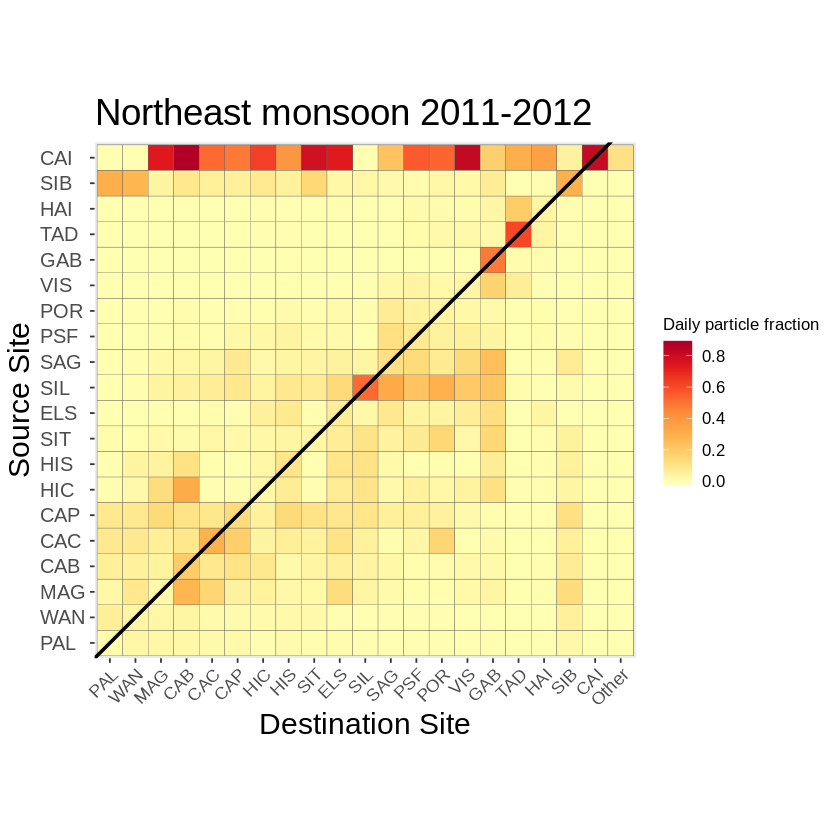

In [94]:
dry12_plot <- ggplot(dry1112, aes(destination, source)) +
geom_tile(aes(fill = val), color = "grey40") +
   geom_tile(aes(fill = val), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
    geom_abline(intercept = 0, slope = 1, color="black", size=1)+
    scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("Northeast monsoon 2011-2012") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

dry12_plot
ggsave(filename="ROMS_8day_conn_NE12_plot.png", plot=dry12_plot, path="~/oceanography/figures" )




Saving 6.67 x 6.67 in image


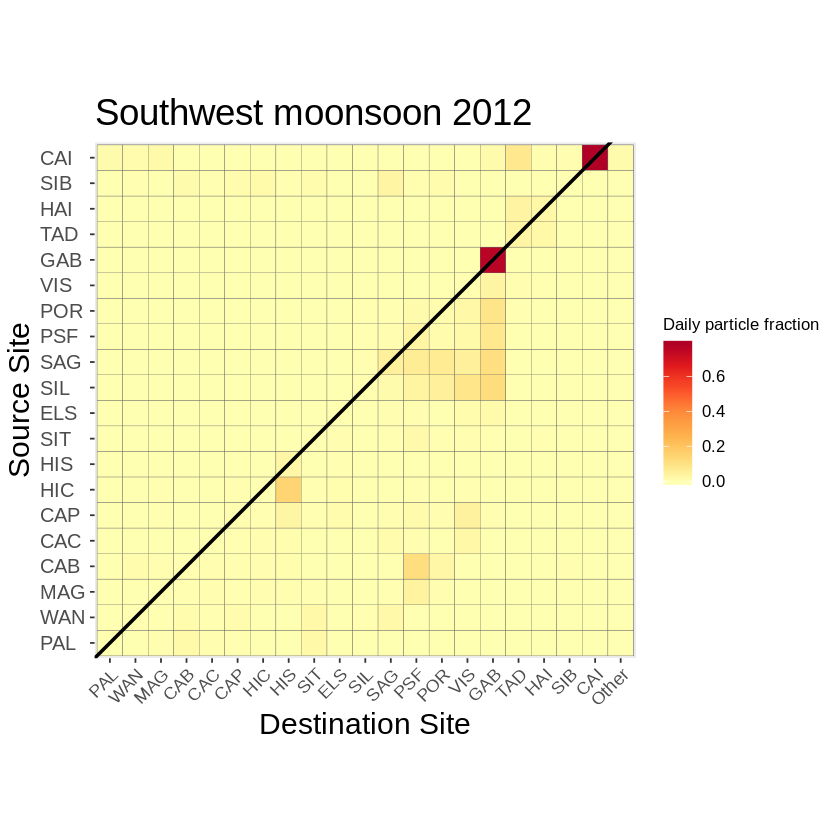

In [93]:
wet12_plot <- ggplot(wet12, aes(destination, source)) +
geom_tile(aes(fill = val), color = "grey40") +
   geom_tile(aes(fill = val), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
    geom_abline(intercept = 0, slope = 1, color="black", size=1)+
    scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("Southwest moonsoon 2012") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

wet12_plot
ggsave(filename="ROMS_8day_conn_SW12_plot.png", plot=wet12_plot, path="~/oceanography/figures" )





Saving 6.67 x 6.67 in image


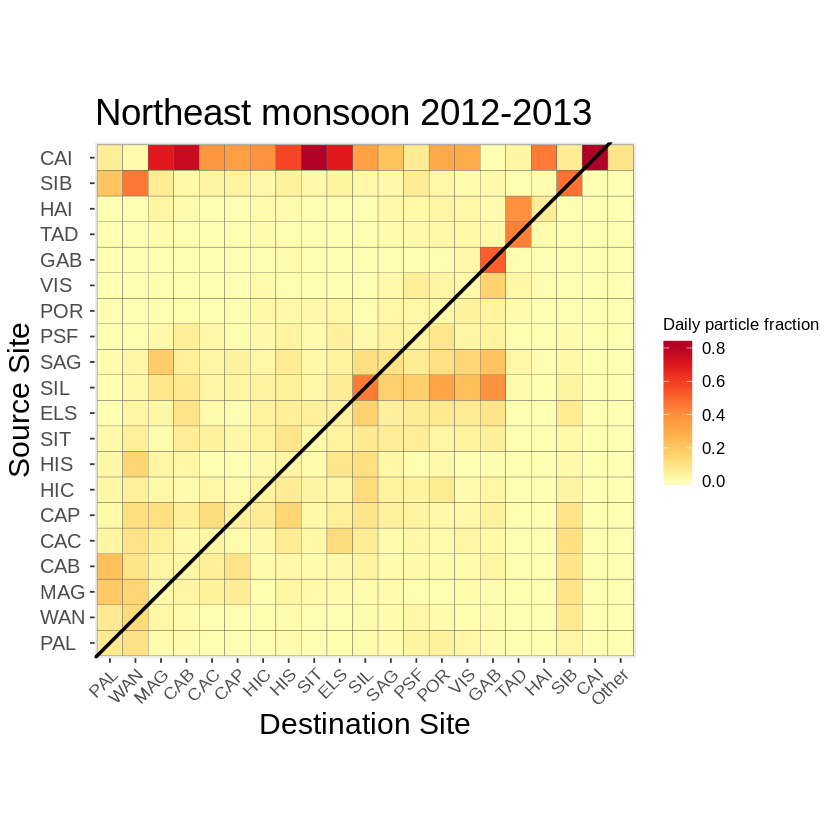

In [92]:
dry13_plot <- ggplot(dry1213, aes(destination, source)) +
geom_tile(aes(fill = val), color = "grey40") +
   geom_tile(aes(fill = val), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
    geom_abline(intercept = 0, slope = 1, color="black", size=1)+
    scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("Northeast monsoon 2012-2013") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

dry13_plot
ggsave(filename="ROMS_8day_conn_NE13_plot.png", plot=dry13_plot, path="~/oceanography/figures" )



Saving 6.67 x 6.67 in image


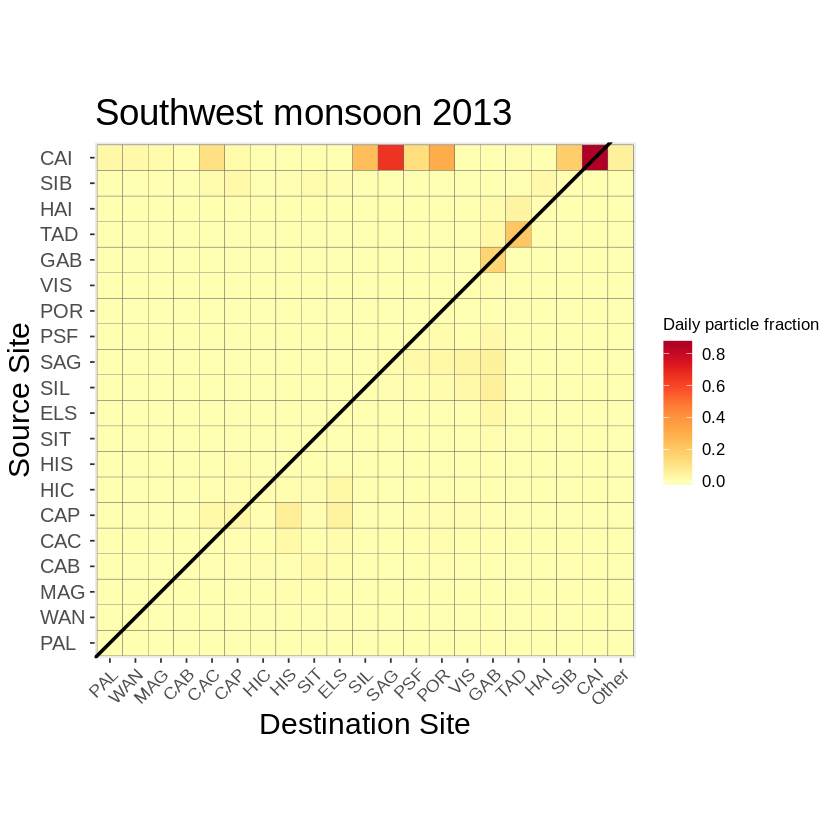

In [91]:
wet13_plot <- ggplot(wet13, aes(destination, source)) +
geom_tile(aes(fill = val), color = "grey40") +
   geom_tile(aes(fill = val), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
    geom_abline(intercept = 0, slope = 1, color="black", size=1)+
    scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("Southwest monsoon 2013") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

wet13_plot
ggsave(filename="ROMS_8day_conn_SW13_plot.png", plot=wet13_plot, path="~/oceanography/figures" )



Saving 6.67 x 6.67 in image


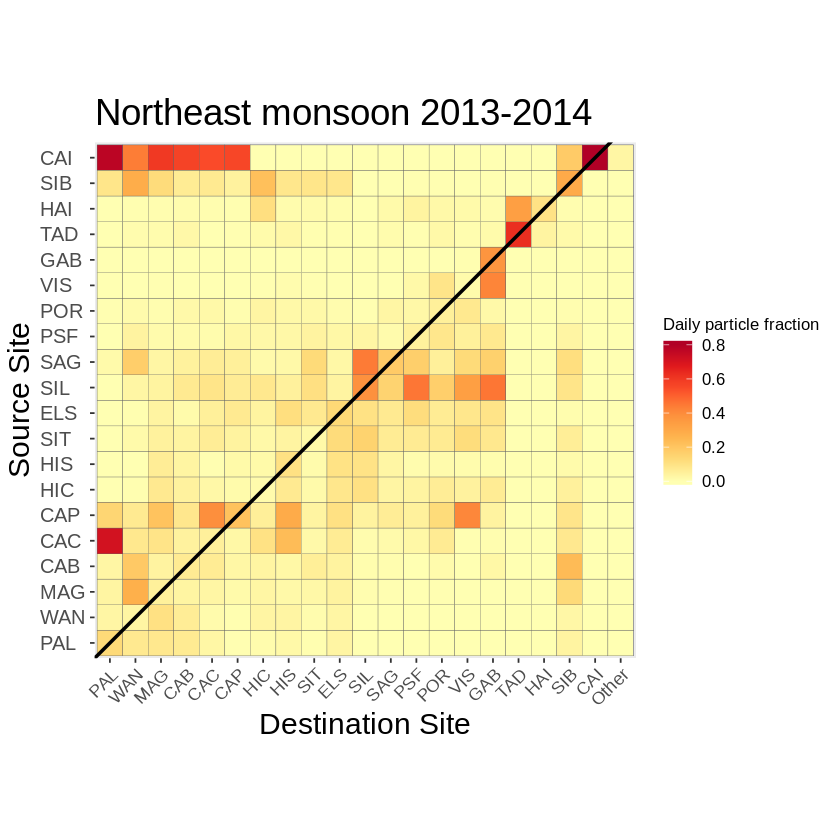

In [96]:
dry14_plot <- ggplot(dry1314, aes(destination, source)) +
geom_tile(aes(fill = val), color = "grey40") +
   geom_tile(aes(fill = val), color = "grey40") +
   #scale_fill_gradient(low = "white", high = "steelblue", name="Immigration Fraction") +
    geom_abline(intercept = 0, slope = 1, color="black", size=1)+
    scale_fill_distiller(palette ="YlOrRd", name="Daily particle fraction", direction=1, na.value="whitesmoke")+ 
   ylab("Source Site") +
   xlab("Destination Site") +
   theme(legend.title = element_text(size = 20),
   legend.text = element_text(size = 20),
   plot.title = element_text(size=22),
   axis.title.y=element_text(size=18),
   axis.title.x=element_text(size=18),
   axis.text.x = element_text(size=11, angle = 45, hjust = 1),
   axis.text.y = element_text(size=12, hjust = 0)) +
   coord_fixed(ratio = 1) +
   theme(axis.text.x=element_text(angle=45,hjust=1)) +
   ggtitle("Northeast monsoon 2013-2014") +
   theme(plot.title = element_text(hjust = 0))+
   theme(legend.text=element_text(size=10))+
   theme(legend.title=element_text(size=10))+ 
   theme(panel.border = element_blank(), panel.grid.major = element_blank(),
   panel.grid.minor = element_blank())

dry14_plot

ggsave(filename="ROMS_8day_conn_NE14_plot.png", plot=dry14_plot, path="~/oceanography/figures" )



In [ ]:
# maybe the transition months show something?
dry1112 <- conn_mat_full4 %>%
    filter(date >= "2011-11-01" & date <= "2012-05-31") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))

wet12 <- conn_mat_full4 %>%
    filter(date >= "2012-06-01" & date <= "2012-11-01") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))


dry1213 <- conn_mat_full4 %>%
    filter(date >= "2012-11-01" & date <= "2013-05-31") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))

wet13 <- conn_mat_full4 %>%
    filter(date >= "2013-06-01" & date <= "2013-11-01") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))



dry1314 <- conn_mat_full4 %>%
    filter(date >= "2013-11-01" & date <= "2014-04-18") %>%
    group_by(source, destination) %>%
    summarise(val=max(fraction))

